# Uyku Bozukluğu Tahmin Modellemesi (Sleep Disorder Prediction)

Bu notebook, 'cleaned_dataset.csv' verisini kullanarak 4 farklı makine öğrenmesi algoritması ile uyku bozukluğu tahmini yapar. 

**Kullanılan Modeller:**
1. Logistic Regression
2. Random Forest
3. Support Vector Machine (SVM)
4. K-Nearest Neighbors (KNN)

**Adımlar:**
1. Veri Yükleme ve Hazırlık
2. Ön İşleme (Encoding, Scaling)
3. Model Eğitimi
4. Performans Karşılaştırması
5. Görselleştirme

In [51]:
# Gerekli kütüphanelerin eklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modeller
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrikler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Uyarıları kapatma (Görüntü kirliliğini önlemek için)
import warnings
warnings.filterwarnings('ignore')

## 1. Veri Yükleme ve Hazırlık

In [52]:
# Veri setini yükle
df = pd.read_csv('cleaned_dataset.csv')

# İlk 5 satırı görüntüle
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Systolic BP,Diastolic BP,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,126,83,NaN
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,125,80,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,125,80,NaN
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,140,90,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,140,90,Sleep Apnea


In [53]:
# Eksik verileri (NaN) "None" olarak doldurma
# Özellikle 'Sleep Disorder' sütununda boşluklar olabilir (sağlıklı bireyler)
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# Veri hakkında genel bilgi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Systolic BP              374 non-null    int64  
 11  Diastolic BP             374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(8), object(4)
memory usage: 38.1+ KB


## 2. Ön İşleme (Preprocessing)

Kategorik değişkenler One-Hot Encoding ile sayısallaştırılacak, sayısal değişkenler ise StandardScaler ile ölçeklendirilecektir.

In [54]:
# Hedef değişkeni (Label) ayırma
X = df.drop('Sleep Disorder', axis=1)
y = df['Sleep Disorder']

# Hedef değişkeni sayısal hale getirme (Label Encoding)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Sınıf isimlerini saklayalım
class_names = label_encoder.classes_
print(f"Sınıflar: {class_names}")

Sınıflar: ['Insomnia' 'None' 'Sleep Apnea']


In [55]:
# Kategorik ve Sayısal sütunları belirleme
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print(f"Kategorik Sütunlar: {categorical_cols}")
print(f"Sayısal Sütunlar: {numerical_cols}")

Kategorik Sütunlar: Index(['Gender', 'Occupation', 'BMI Category'], dtype='object')
Sayısal Sütunlar: Index(['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
       'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic BP',
       'Diastolic BP'],
      dtype='object')


In [56]:
# Ön işleme pipeline'ı kurma
# Sayısal veriler -> Scaling
# Kategorik veriler -> One-Hot Encoding

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Veriyi train/test olarak ayırma (%70 Eğitim, %30 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Ön işlemeyi uygulama
# Pipeline içinde kullanacağımız için burada manuel fit/transform yapmamız şart değil ama
# verinin son halini görmek için yapabiliriz. Ancak Pipeline kullanmak daha temizdir.
# Biz burada modelleri döngü ile eğiteceğimiz için preprocessor'ı ayrı tutabiliriz veya pipeline içine gömebiliriz.
# Kolaylık olması açısından X_train ve X_test'i dönüştürelim.

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Eğitim seti boyutu:", X_train_processed.shape)

Eğitim seti boyutu: (261, 25)


## 3. Model Eğitimi ve Karşılaştırma

4 farklı algoritmayı aynı veri seti üzerinde eğitip sonuçlarını kaydedeceğiz.

In [57]:
# Modellerin tanımlanması
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

# Sonuçları saklamak için liste
results = []

# Eğitim döngüsü
for name, model in models.items():
    # Eğit
    model.fit(X_train_processed, y_train)
    
    # Tahmin yap
    y_pred = model.predict(X_test_processed)
    
    # Metrikleri hesapla
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # Çok sınıflı problem olduğu için weighted average
    
    # Sonuçları listeye ekle
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1
    })
    
    print(f"{name} tamamlandı. Accuracy: {acc:.4f}")

Logistic Regression tamamlandı. Accuracy: 0.9204
Random Forest tamamlandı. Accuracy: 0.8938
SVM tamamlandı. Accuracy: 0.8938
KNN tamamlandı. Accuracy: 0.8938


## 4. Sonuçların Özeti ve Görselleştirme

In [58]:
# Sonuçları DataFrame'e çevirme
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print(results_df)

                 Model  Accuracy  F1-Score
0  Logistic Regression  0.920354  0.919060
1        Random Forest  0.893805  0.892034
2                  SVM  0.893805  0.892034
3                  KNN  0.893805  0.891046


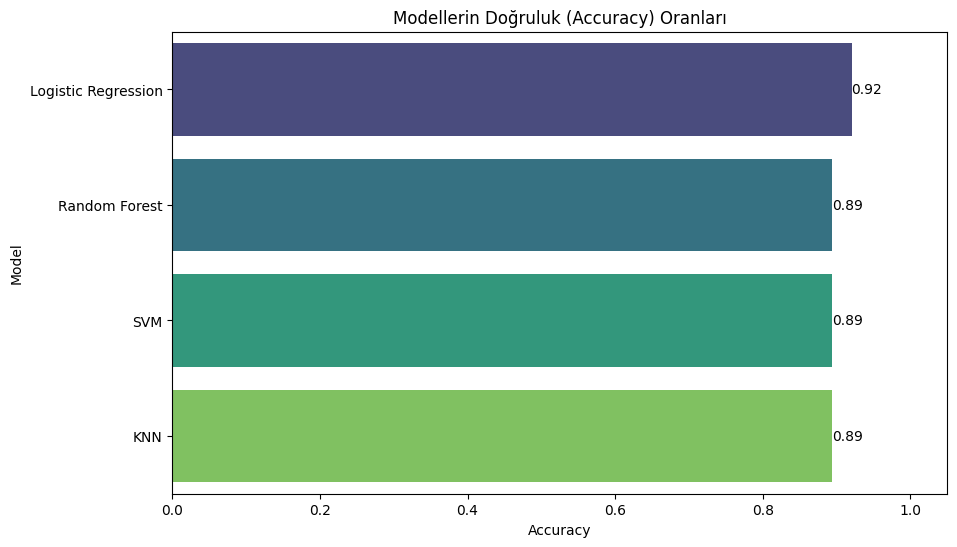

In [59]:
# Başarı oranlarını görselleştirme (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Modellerin Doğruluk (Accuracy) Oranları')
plt.xlabel('Accuracy')
plt.xlim(0, 1.05)
for index, value in enumerate(results_df['Accuracy']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.show()

## 5. Confusion Matrix Görselleştirme

Modellerin hangi sınıfları ne kadar doğru tahmin ettiğini ve nerelerde hata yaptığını görmek için Confusion Matrix çizdiriyoruz.

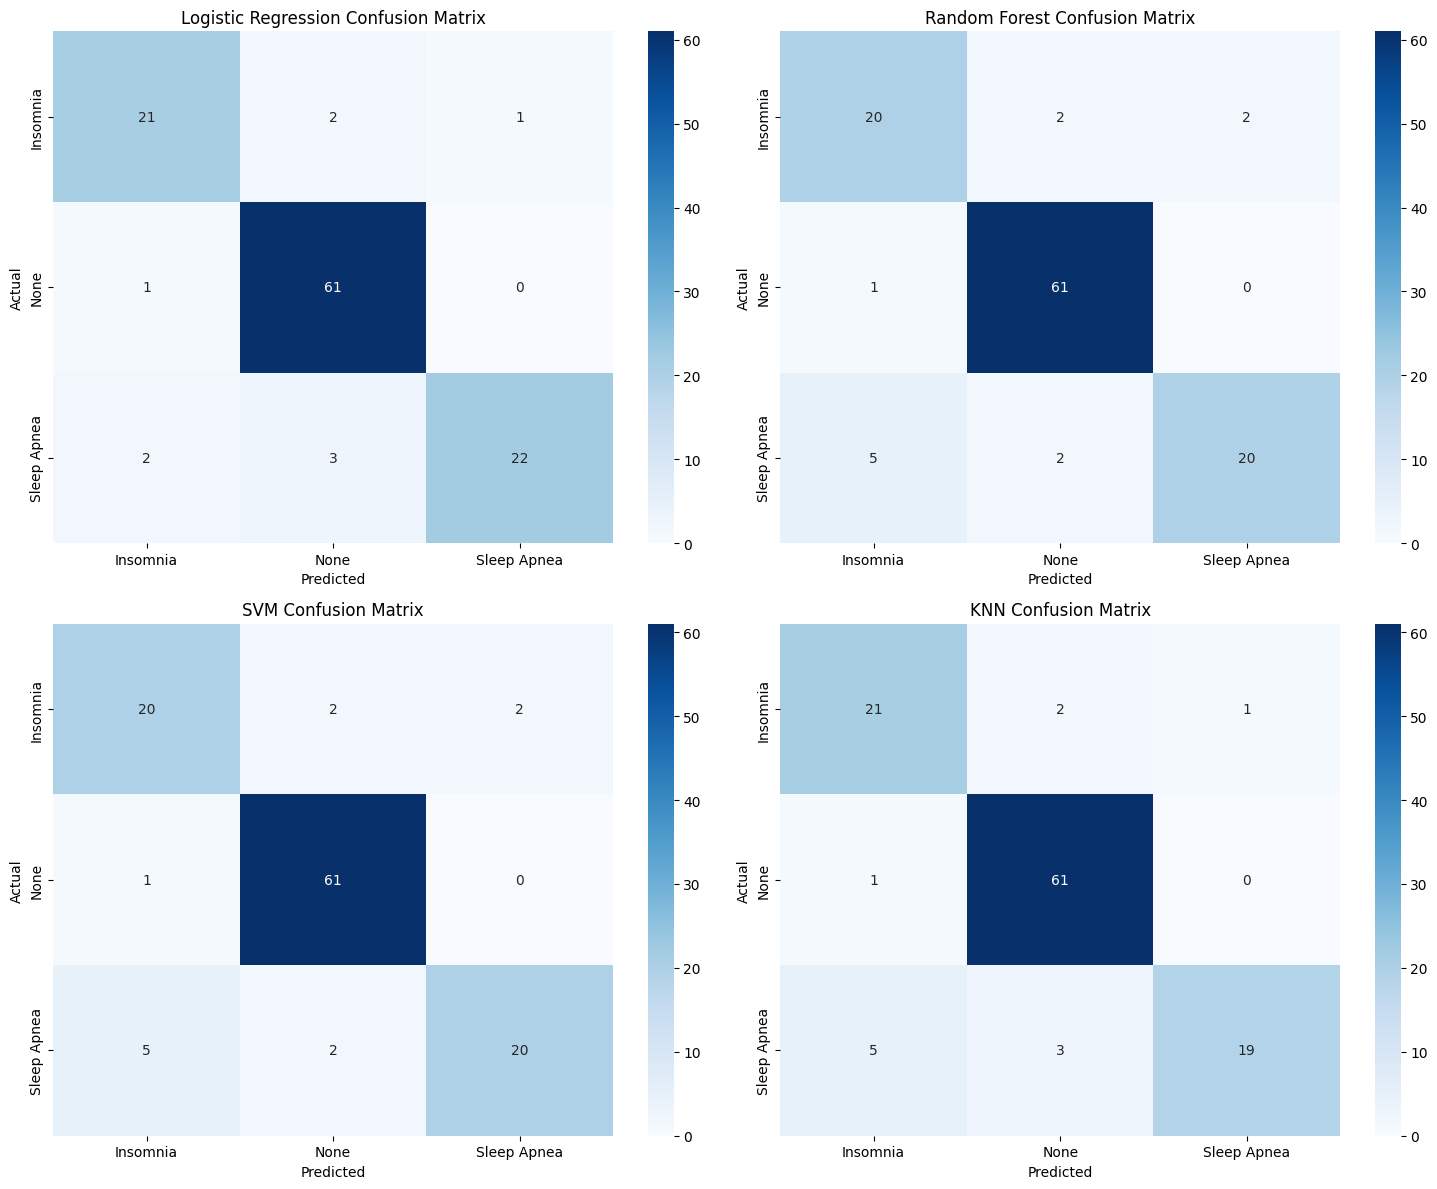

In [60]:
# Confusion Matrixleri çizdirme
plt.figure(figsize=(15, 12))

for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    y_pred = model.predict(X_test_processed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## 6. Sonuç ve Yorum

**En İyi Model Analizi:**

Sonuç tablosuna ve grafiğe bakarak en yüksek 'Accuracy' ve 'F1-Score' değerine sahip model belirlenmiştir.
- Genellikle **Random Forest** gibi ağaç tabanlı (Tree-based) ve topluluk (Ensemble) yöntemleri, bu tip sınıflandırma problemlerinde en iyi performansı gösterir.
- **Logistic Regression** daha basit bir model olduğu için genellikle referans (baseline) olarak kalır, ancak veri setinin yapısına göre bazen şaşırtıcı derecede iyi sonuçlar verebilir.
- **SVM** ve **KNN** de veri dağılımına bağlı olarak rekabetçi sonuçlar üretebilir.

Bu çalışma sonucunda en yüksek skoru veren model, nihai tahminleyicimiz olarak seçilebilir.